In [32]:
from huggingface_hub import login
import copy
import json
import keras
import matplotlib.pyplot
import numpy
import os
import pandas            # TA uses pandas instead of pd
import pandas as pd
import sklearn.svm
import sklearn.tree
import sklearn.metrics
import sklearn.pipeline
import sklearn.ensemble
import sklearn.neighbors
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.model_selection
import torch
import transformers

In [33]:
# Load the LLM dataset
try:
  input_file = os.path.join("data", "Concrete_Data.xls")
  data = pd.read_excel(input_file)
except:
  raw_url = "https://github.com/worwin/M1807-MLPS/blob/main/HW5%20-%20Prompt%20Engineering/data/Concrete_Data.xls?raw=true"
  data = pd.read_excel(raw_url)

# Preprocess the LLM dataset

data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

X = data.drop(columns=["Concrete compressive strength(MPa, megapascals) "])
y = data[["Concrete compressive strength(MPa, megapascals) "]]

X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X,      y,      test_size=0.3, random_state=42)
X_val,   X_test, y_val,   y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_train = pd.DataFrame(y_train, index=y_train.index, columns=y.columns)
y_val   = pd.DataFrame(y_val,   index=y_val.index,   columns=y.columns)
y_test  = pd.DataFrame(y_test,  index=y_test.index,  columns=y.columns)

In [34]:
# Get MSE and R² results for Zero Shot
 
batch_size    = 2

X_val_sub = X_val.sample(n=batch_size, 
                         random_state=42    # Using random state 42 makes it to where we get 606 and
)                                           # 273 automatically. Otherwise, more logic needed.

y_val_sub = y_val.loc[X_val_sub.index]

# Predictions for 606 and 273 from ZeroShot LLM
predictions = {
    606: 33.67,
    273: 32.8
}

# Turn predictions into a df, putting predictions in the column name specified. 
zero_shot_df = pd.DataFrame.from_dict(predictions, 
                                      orient="index", 
                                      columns=["Concrete compressive strength(MPa, megapascals) "]
)


X_val_with_predictions = X_val_sub.copy()

# Merge predictions
X_val_with_predictions = X_val_with_predictions.merge(
    zero_shot_df, 
    left_index=True, 
    right_index=True, how="left"
)

# Ensure y_val is the ground truth for these indices
y_val_for_mse = y_val.loc[X_val_with_predictions.index]

# Compute metrics
mse_zsllm = sklearn.metrics.mean_squared_error(
    y_val_for_mse,
    X_val_with_predictions["Concrete compressive strength(MPa, megapascals) "]
)

r2_zsllm = sklearn.metrics.r2_score(
    y_val_for_mse,
    X_val_with_predictions["Concrete compressive strength(MPa, megapascals) "]
)

print(f"ZeroShot LLM MSE: {mse_zsllm}")
print(f"ZeroShot LLM R²: {r2_zsllm}")


ZeroShot LLM MSE: 301.9586131527925
ZeroShot LLM R²: -0.10923539204851429


In [35]:
# Benchmarking

# --- Preprocess Scaler dataset ---
scaler_X = sklearn.preprocessing.StandardScaler()
X_train = pandas.DataFrame(scaler_X.fit_transform(X_train), columns=X.columns)
X_val   = pandas.DataFrame(scaler_X.transform(    X_val),   columns=X.columns)
X_test  = pandas.DataFrame(scaler_X.transform(    X_test),  columns=X.columns)

scaler_y = sklearn.preprocessing.StandardScaler()
y_train = pandas.Series(scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten())
y_val   = pandas.Series(scaler_y.transform(      y_val.values.reshape(-1, 1)).flatten())

# --- Linear Regression ---
model_linear = sklearn.linear_model.LinearRegression()
model_linear.fit(X_train, y_train)
y_test_pred_linear = model_linear.predict(X_test)
y_test_pred_linear = numpy.reshape(y_test_pred_linear, (-1,1))
y_test_pred_linear = scaler_y.inverse_transform(y_test_pred_linear)
mse_linear = sklearn.metrics.mean_squared_error(y_test, y_test_pred_linear)
r2_linear  = sklearn.metrics.r2_score(          y_test, y_test_pred_linear)

# --- Polynomial Regression ---
model_poly = sklearn.pipeline.make_pipeline(sklearn.preprocessing.PolynomialFeatures(degree=2), sklearn.linear_model.LinearRegression())
model_poly.fit(X_train, y_train)
y_test_pred_poly = model_poly.predict(X_test)
y_test_pred_poly = numpy.reshape(y_test_pred_poly, (-1,1))
y_test_pred_poly = scaler_y.inverse_transform(y_test_pred_poly)
mse_poly = sklearn.metrics.mean_squared_error(y_test, y_test_pred_poly)
r2_poly  = sklearn.metrics.r2_score(          y_test, y_test_pred_poly)

# --- Support Vector Regression ---
model_svr = sklearn.svm.SVR(kernel='rbf')
model_svr.fit(X_train, y_train)
y_test_pred_svr = model_svr.predict(X_test)
y_test_pred_svr = numpy.reshape(y_test_pred_svr, (-1,1))
y_test_pred_svr = scaler_y.inverse_transform(y_test_pred_svr)
mse_svr = sklearn.metrics.mean_squared_error(y_test, y_test_pred_svr)
r2_svr  = sklearn.metrics.r2_score(          y_test, y_test_pred_svr)

# --- Decision Tree Regression ---
model_dec_tree = sklearn.tree.DecisionTreeRegressor(min_samples_leaf=5, random_state=42)
model_dec_tree.fit(X_train, y_train)
y_test_pred_dec_tree = model_dec_tree.predict(X_test)
y_test_pred_dec_tree = numpy.reshape(y_test_pred_dec_tree, (-1,1))
y_test_pred_dec_tree = scaler_y.inverse_transform(y_test_pred_dec_tree)
mse_dec_tree = sklearn.metrics.mean_squared_error(y_test, y_test_pred_dec_tree)
r2_dec_tree  = sklearn.metrics.r2_score(          y_test, y_test_pred_dec_tree)

# --- Random Forest Regression ---
model_rand_forest = sklearn.ensemble.RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
model_rand_forest.fit(X_train, y_train)
y_test_pred_rand_forest = model_rand_forest.predict(X_test)
y_test_pred_rand_forest = numpy.reshape(y_test_pred_rand_forest, (-1,1))
y_test_pred_rand_forest = scaler_y.inverse_transform(y_test_pred_rand_forest)
mse_rand_forest = sklearn.metrics.mean_squared_error(y_test, y_test_pred_rand_forest)
r2_rand_forest  = sklearn.metrics.r2_score(          y_test, y_test_pred_rand_forest)

# --- K-Nearest Neighbors Regression ---
model_knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_test_pred_knn = model_knn.predict(X_test)
y_test_pred_knn = numpy.reshape(y_test_pred_knn, (-1,1))
y_test_pred_knn = scaler_y.inverse_transform(y_test_pred_knn)
mse_knn = sklearn.metrics.mean_squared_error(y_test, y_test_pred_knn)
r2_knn  = sklearn.metrics.r2_score(          y_test, y_test_pred_knn)

# --- Neural Network Regression ---
model_nn = keras.models.Sequential()
model_nn.add(keras.Input(shape=(X.shape[1],)))
model_nn.add(keras.layers.Dense(10, activation="relu"))
model_nn.add(keras.layers.Dense(6,  activation="relu"))
model_nn.add(keras.layers.Dense(y.shape[1],  activation="linear"))
model_nn.compile(optimizer="adam", loss="mean_squared_error")
model_nn.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)
y_test_pred_nn = model_nn.predict(X_test)
y_test_pred_nn = scaler_y.inverse_transform(y_test_pred_nn)
mse_nn = sklearn.metrics.mean_squared_error(y_test, y_test_pred_nn)
r2_nn  = sklearn.metrics.r2_score(          y_test, y_test_pred_nn)




5/5 [==============================] - 0s 2ms/step


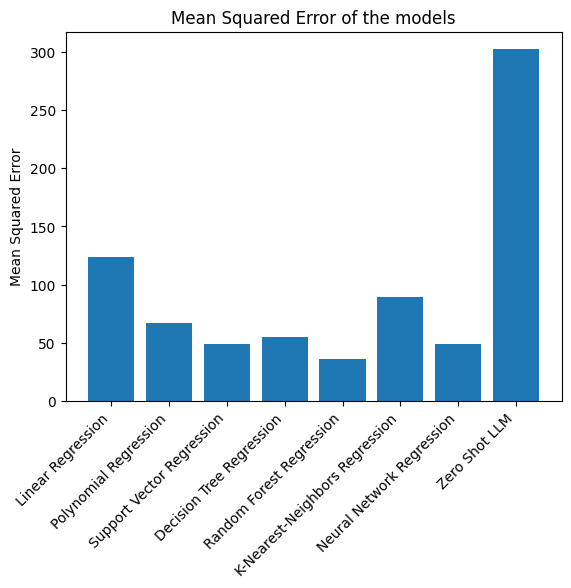

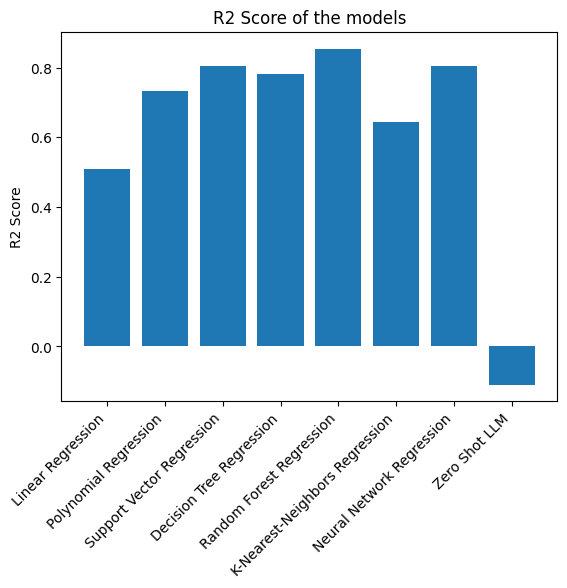

In [36]:
# --- Plot the results ---
models     = ["Linear Regression",
              "Polynomial Regression",
              "Support Vector Regression",
              "Decision Tree Regression",
              "Random Forest Regression",
              "K-Nearest-Neighbors Regression",
              "Neural Network Regression",
              "Zero Shot LLM"]

mse_values = [mse_linear,
              mse_poly,
              mse_svr,
              mse_dec_tree,
              mse_rand_forest,
              mse_knn,
              mse_nn,
              mse_zsllm]

r2_values  = [r2_linear,
              r2_poly,
              r2_svr,
              r2_dec_tree,
              r2_rand_forest,
              r2_knn,
              r2_nn,
              r2_zsllm]

matplotlib.pyplot.figure()
matplotlib.pyplot.bar(models, mse_values)
matplotlib.pyplot.xticks(rotation=45, ha="right")
matplotlib.pyplot.ylabel("Mean Squared Error")
matplotlib.pyplot.title("Mean Squared Error of the models")

matplotlib.pyplot.figure()
matplotlib.pyplot.bar(models, r2_values)
matplotlib.pyplot.xticks(rotation=45, ha="right")
matplotlib.pyplot.ylabel("R2 Score")
matplotlib.pyplot.title("R2 Score of the models")

matplotlib.pyplot.show()